In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from datetime import datetime
import csv

# Truncated SVD -- LSA (Latent Semantic Analysis)

Essai d'une methode de classification de messages courts

## Données

In [5]:
data_1 = pd.read_json('Data\messages_chat_seance1\\0dfd43cb-9957-4102-954a-899ca075e56d.json')
data_2 = pd.read_json('Data\messages_chat_seance1\\1db9dee2-2702-457f-aa07-6b60589446ce.json')
data_3 = pd.read_json('Data\messages_chat_seance1\\2ccf746f-62b9-4690-8bff-59c49fb2c310.json')

In [6]:
##Fonction(s) pour traiter les messages

def parse_json_files_in_folder(folder_path):
    """
    Parses all JSON files in a folder and concatenates them into a pandas DataFrame.

    Args:
        folder_path (str): The path to the folder containing the JSON files.

    Returns:
        pandas.DataFrame: A DataFrame containing the concatenated data from all JSON files.
    """
    all_data = pd.DataFrame()
    groupid = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            filepath = os.path.join(folder_path, filename)
            data = pd.read_json(filepath)
            data['groupID'] = groupid
            data['fileID'] = filename[:-5]
            all_data = pd.concat([all_data,data],axis = 0)
            groupid += 1
    all_data.reset_index(inplace = True, drop = True)
    all_data.index.names = ["messageID"]
    # extracting date from timestamp
    all_data['date'] = [datetime.date(d) for d in all_data['timestamp']] 

    # extracting time from timestamp
    all_data['time'] = [datetime.time(d).replace(microsecond=0) for d in all_data['timestamp']]
    all_data.drop(['timestamp'],axis = 1,inplace = True)
    return all_data


In [9]:
seance1_df = parse_json_files_in_folder('Data\messages_chat_seance1')
print("seance1_df shape : ",seance1_df.shape)
seance1_df.head()

seance1_df shape :  (451, 7)


,user,role,message,groupID,fileID,date,time
messageID,,,,,,,
0,186202.0,Navigator,"Tu es qui ,",0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:10
1,186202.0,Navigator,On se met 5 partout ok ?,0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:23
2,183897.0,Driver,Opé,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:22
3,183897.0,Driver,Opé lmkt,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:39
4,193392.0,Navigator,A PAR SA LE COUZ,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:46


In [10]:
seance2_df = parse_json_files_in_folder('Data\messages_chat_seance2')
print("seance2_df shape : ",seance2_df.shape)
seance2_df.head()

seance2_df shape :  (1315, 7)


,groupID,fileID,user,role,message,date,time
messageID,,,,,,,
0,1,00c09563-99f4-42da-9346-d73355a9b8d9,183337.0,Driver,bonjour,2024-11-12,04:30:24
1,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,bonjour,2024-11-12,04:30:44
2,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Navigator,tu es bloqué?,2024-11-12,04:36:03
3,1,00c09563-99f4-42da-9346-d73355a9b8d9,145133.0,Driver,hésite pas si t'as une idée,2024-11-12,04:39:50
4,1,00c09563-99f4-42da-9346-d73355a9b8d9,183337.0,Navigator,ok,2024-11-12,04:40:06


In [11]:
all_messages_df = pd.concat([seance1_df,seance2_df],axis = 0,ignore_index = True)
all_messages_df.index.names=['messageID']
#print(all_messages_df.head(5),all_messages_df.tail(5))
all_messages_df.head()

,user,role,message,groupID,fileID,date,time
messageID,,,,,,,
0,186202.0,Navigator,"Tu es qui ,",0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:10
1,186202.0,Navigator,On se met 5 partout ok ?,0,023a3090-7b0a-48c4-93f0-c200d9afce41,2024-10-09,04:38:23
2,183897.0,Driver,Opé,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:22
3,183897.0,Driver,Opé lmkt,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:39
4,193392.0,Navigator,A PAR SA LE COUZ,1,0435458c-dc49-4094-b970-1db125fc235c,2024-10-09,04:21:46


In [12]:
#Messages sous forme de tableau
seance1_msg = seance1_df['message'].values #Récupère les valeurs de la colonne message et en fait une liste
print(len(seance1_msg))
#print(seance1_msg)
seance2_msg = seance2_df['message'].values #Récupère les valeurs de la colonne message et en fait une liste
print(len(seance2_msg))
#print(seance2_msg)
all_msg= all_messages_df['message'].values
print(len(all_msg))

451
1315
1766


## LSA

In [13]:
tokenizer = RegexpTokenizer(r'\b\w{3,}\b') #garde les mots d'au moins trois lettres, avec dans les mots soit des lettres, soit des chiffres (pas de caractères spéciaux)
stop_words = list(set(stopwords.words("french"))) #On enlève les mots communs sans interêt en français ; on garde ceux en anglais car indique probablement du code
print(stop_words)
stop_words += list(string.punctuation)

['étées', 'ma', 'soyez', 'fûmes', 'ta', 'fusse', 't', 'qu', 'avaient', 'fussions', 'auront', 'aies', 'ou', 'étés', 'êtes', 'fût', 'ayante', 'serai', 'votre', 'eussent', 'du', 'fussent', 'eu', 'avions', 'moi', 'te', 'ai', 'vos', 'au', 'aviez', 'ne', 'son', 'seras', 'fut', 'serions', 'ses', 'que', 'eue', 'furent', 'des', 'n', 'eusses', 'eûmes', 'était', 'lui', 'ce', 'vous', 'toi', 'fus', 'seront', 'étaient', 'une', 'avais', 'avons', 'fusses', 'elle', 'eus', 'été', 'pas', 'étais', 'en', 'serais', 'tu', 'serons', 'eût', 'eusse', 'étante', 'auriez', 'le', 'fûtes', 'ces', 'aurais', 'ils', 'étiez', 'fussiez', 'eurent', 'sera', 'm', 'et', 'la', 'as', 'sont', 'nous', 'mes', 'avez', 'nos', 'eussiez', 'par', 'avait', 's', 'ait', 'ayons', 'les', 'mais', 'y', 'eussions', 'dans', 'j', 'suis', 'soyons', 'd', 'même', 'est', 'aurons', 'il', 'es', 'eûtes', 'à', 'auras', 'mon', 'aux', 'étée', 'aient', 'leur', 'ayantes', 'tes', 'serez', 'aurez', 'auraient', 'me', 'je', 'aie', 'aura', 'étions', 'un', 'eues

In [14]:
#tf-idf = Term Frequency Inverse Document Frequency of records
#tf = term frequency
#idf = inverse codument frequency (les mots les plus communs dans les documents semblent moins significatifs)
tfidf = TfidfVectorizer(lowercase=True, #Convertir tous les caractères en lowercase avant de tokenize
                        stop_words=stop_words,
                        tokenizer=tokenizer.tokenize,
                        max_df=0.7, #ignore les items ayant une fréquence supérieure à x
                        min_df=0.015 #ignore les items ayant une fréquence inférieure à x
                        )

tfidf_train_sparse = tfidf.fit_transform(all_msg) # equivalent à fit puis transform : fit entraine le modèle, transform applique le modele sur le dataset
#Crée un DF avec les résultats
tfidf_train_df = pd.DataFrame(tfidf_train_sparse.toarray(), #transforme une matrice en tableau 2D
                        columns=tfidf.get_feature_names_out()) #get output feature names for transfomation = les mots // les noms des colonnes ?

print('Shape :',tfidf_train_df.shape)
tfidf_train_df.head(2)

Shape : (1766, 20)


c:\Users\cbd65\anaconda3\envs\jupyterenv\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,accord,alors,bon,code,comment,faire,fait,faut,main,marche,non,ouais,oui,peut,peux,quoi,sais,salut,veux,vois
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
#Transforme la matrice du dessus en une autre plus réduite en utilisant la décomposition en valeurs singulières A = U * Sigma * V_T.

#n_components = dimension de l'output (100 recommendé pour LSA, doit être <= au nombre de features)
lsa_obj = TruncatedSVD(n_components=20, n_iter=100, random_state=42)
tfidf_lsa_data = lsa_obj.fit_transform(tfidf_train_df)
Sigma = lsa_obj.singular_values_ # Matrice centrale, valeurs correcspondant à chaque composant sélectionné
V_T = lsa_obj.components_.T # components_ = vecteurs singuliers de droite de l'input data
print("V_T shape : ",V_T.shape)

V_T shape :  (20, 20)


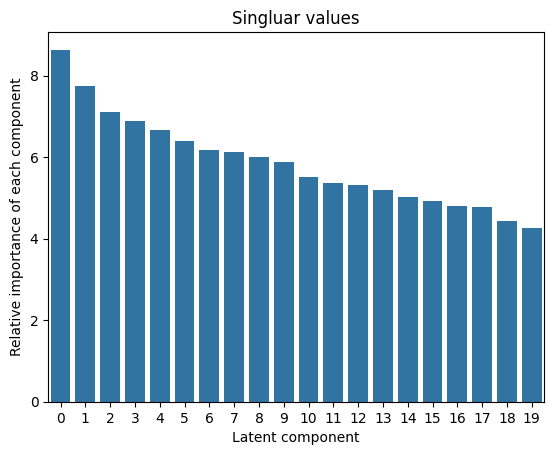

In [16]:
#Affichage de l'importance de chaque composante
axis_object = sns.barplot(x=list(range(len(Sigma))), y = Sigma)
plt.xlabel("Latent component")
plt.ylabel('Relative importance of each component')
plt.title("Singluar values")
plt.show(axis_object)

In [17]:
#Transformation de V_T en DF pour une utilisation plus facile
term_topic_matrix = pd.DataFrame(data=V_T,
                                index = tfidf_train_df.columns,
                                columns = [f'Latent_concept_{r}' for r in range(0,V_T.shape[1])])
term_topic_matrix.head(3)

,Latent_concept_0,Latent_concept_1,Latent_concept_2,Latent_concept_3,Latent_concept_4,Latent_concept_5,Latent_concept_6,Latent_concept_7,Latent_concept_8,Latent_concept_9,Latent_concept_10,Latent_concept_11,Latent_concept_12,Latent_concept_13,Latent_concept_14,Latent_concept_15,Latent_concept_16,Latent_concept_17,Latent_concept_18,Latent_concept_19
accord,0.000928,0.016293,0.000171,-0.003118,0.001658,0.006144,-0.000157,0.000856,-0.036171,0.050127,0.160689,0.984804,0.010571,0.005504,-0.000655,0.003536,-0.003030,-0.005970,-0.000479,0.001616
alors,0.049660,0.017007,0.035078,0.024378,-0.017633,-0.011354,-0.029615,0.020229,-0.060315,-0.004037,-0.011294,-0.004270,0.070625,0.059487,0.791988,-0.015817,0.008033,-0.553939,-0.216302,-0.013155
bon,0.985261,-0.064074,-0.122452,0.026434,-0.012944,-0.064455,-0.005331,-0.032283,0.010439,-0.007084,0.009906,0.000213,-0.032917,0.002660,-0.048351,-0.010608,0.006613,0.008716,-0.005879,0.010858


In [18]:
def visualize_top_bottom_terms_component(matrix,nbComponent):
    name_col = 'Latent_concept_'+str(nbComponent)
    data = matrix[name_col]
    data = data.sort_values(ascending=False)
    top_10 = data[:10]
    data = data.sort_values(ascending=True)
    bottom_10 = data[:10]
    #fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(5,5))

    fig, (ax1,ax2) = plt.subplots(1,2)

    y_pos = np.arange(len(top_10.index))

    ax1.barh(y_pos, top_10.values, align='center')
    ax1.set_yticks(y_pos, labels=top_10.index)
    ax1.invert_yaxis()  # labels read top-to-bottom
    ax1.set_title('Component '+str(nbComponent)+' : Top 10')

    #fig, ax = plt.subplots(1,2,2)

    y_pos = np.arange(len(bottom_10.index))

    ax2.barh(y_pos, bottom_10.values, align='center')
    ax2.set_yticks(y_pos, labels=bottom_10.index)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Component '+str(nbComponent)+' : Bottom 10')

    plt.tight_layout()
    plt.show()


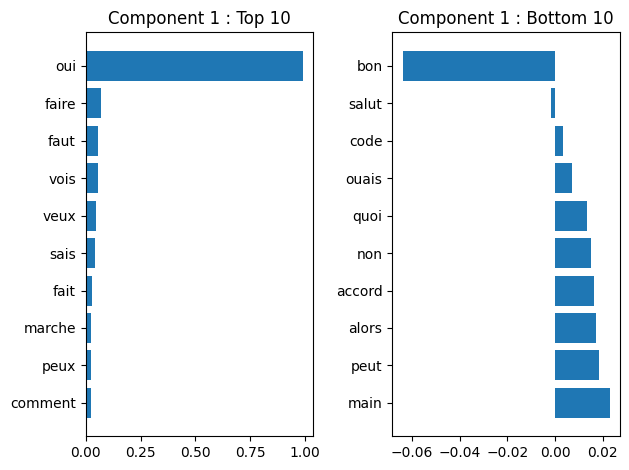

In [19]:
visualize_top_bottom_terms_component(term_topic_matrix,1)

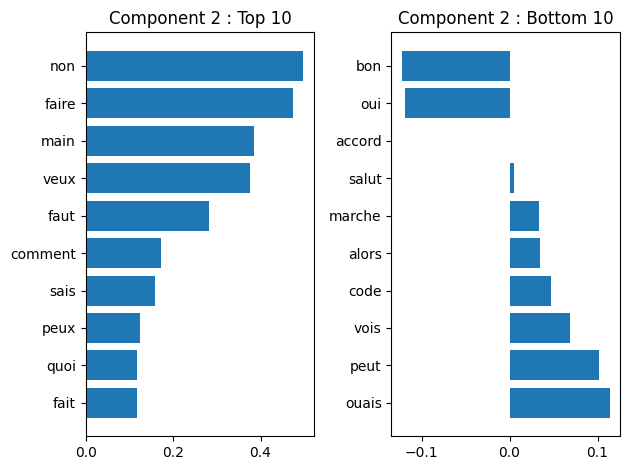

In [20]:
visualize_top_bottom_terms_component(term_topic_matrix,2)

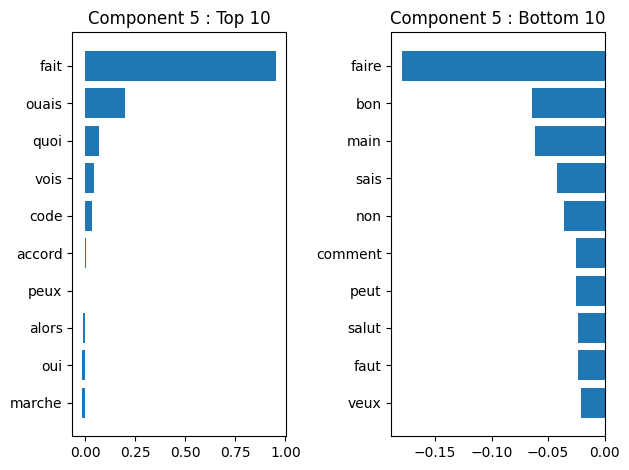

In [21]:
visualize_top_bottom_terms_component(term_topic_matrix,5)

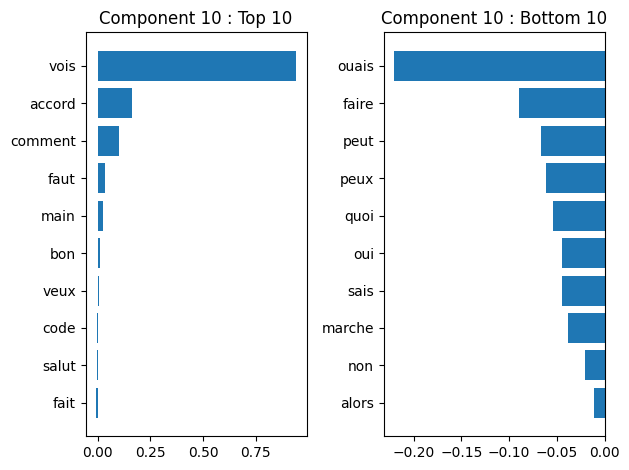

In [22]:
visualize_top_bottom_terms_component(term_topic_matrix,10)